In [1]:
generate_data = False

Create plots that form basis for sketch

In [2]:
import numpy as np
import run_continuum as run
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from frictionlaws import SlipWeakeningFrictionLaw
from predictions import *

import pickle

In [3]:
# Run simulations
if generate_data:
    data = []
    dataCrack = []

    for simulation in ['yield stress barrier','stress barrier','fracture energy barrier', 'slowly varying prestress', 'slowly varying fracture energy']:

        if simulation == 'yield stress barrier': # No slip bc on the right
            x = np.linspace(0,50,5000)
            tau = gauss(x,0,5)*.7+.3
            tau[x<.2]=1
            tauCrack = gauss(x,0,5)*.99+.01
            tauCrack[x<.2]=1
            dc = np.ones(np.size(tau))*1e-2
            dcCrack = np.ones(np.size(tau))*1e-2

        elif simulation == 'stress barrier': # Low stress region
            x = np.linspace(0,100,10000)
            tau = gauss(x,0,5)*.7+.3
            tau[x<.2]=1
            tau[x>30]=-.3
            tau[x>70]=.3
            tauCrack = gauss(x,0,5)*.99+.01
            tauCrack[x<.2]=1
            tauCrack[x>30]=-.3
            tauCrack[x>70]=.01
            dc = np.ones(np.size(tau))*1e-2
            dcCrack = np.ones(np.size(tau))*1e-2

        elif simulation == 'fracture energy barrier': # High dc region
            x = np.linspace(0,100,10000)
            tau = gauss(x,0,5)*.7+.3
            tau[x<.2]=1
            tauCrack = gauss(x,0,3)*.99+.01
            tauCrack[x<.2]=1

            dc = np.ones(np.size(tau))*1e-2
            dc[x>30]=1.0
            dc[x>70]=1e-2
            dcCrack = np.ones(np.size(tau))*1e-2
            dcCrack[x>30]=1.0 ## 1.5
            dcCrack[x>70]=1e-2

        elif simulation == 'slowly varying prestress': # High dc region
            x = np.linspace(0,100,10000)
            tau = np.linspace(1,-.9,len(x))
            tau[x<.2]=1
            tauCrack = np.linspace(1,-.9,len(x))
            tauCrack[x<.2]=1
            dc = np.ones(np.size(tau))*1e-2
            dcCrack = np.ones(np.size(tau))*1e-2

        elif simulation == 'slowly varying fracture energy': # High dc region
            x = np.linspace(0,100,10000)
            tau = gauss(x,0,2)*.7+.3
            tau[x<.1]=1
#            tauCrack = gauss(x,0,1)*.99+.01
            tauCrack = gauss(x,0,1)*.99+.015
            tauCrack[x<.1]=1
            dc = np.linspace(0,.3,len(x))
#            dcCrack = np.linspace(0,.15,len(x))
            dcCrack = np.linspace(0,.3,len(x))            

        # Run simulation with gamma = 0.65
        data.append(run.run_continuum(x = x, 
                                 tau = tau, 
                                 tau_minus = tau+10, 
                                 dt = 1e-3, 
                                 output_interval = 100,
                                 gamma = 0.65,
                                 tmax = 100, 
                                 beta = 1e-3,
                                 bc='fixed',
                                 frictionLaw = SlipWeakeningFrictionLaw(dc=dc,delta_u = np.zeros(np.size(x)))))

        # Run simulation with gamma = 0
        dataCrack.append(run.run_continuum(x = x, 
                                 tau = tauCrack, 
                                 tau_minus = tau+10, 
                                 dt = 1e-3, 
                                 output_interval = 100,
                                 gamma = 0,
                                 tmax = 200, 
                                 beta = 1e-3,
                                 bc='fixed',
                                 frictionLaw = SlipWeakeningFrictionLaw(dc=dcCrack,delta_u = np.zeros(np.size(x)))))
        
    pickle.dump({'dataCrack': dataCrack, 'data': data},  open( "data/sketch.p", "wb" ))        
else:
    data = pickle.load( open( "data/sketch.p", "rb" ) )
    dataCrack = data['dataCrack']
    data = data['data']
        

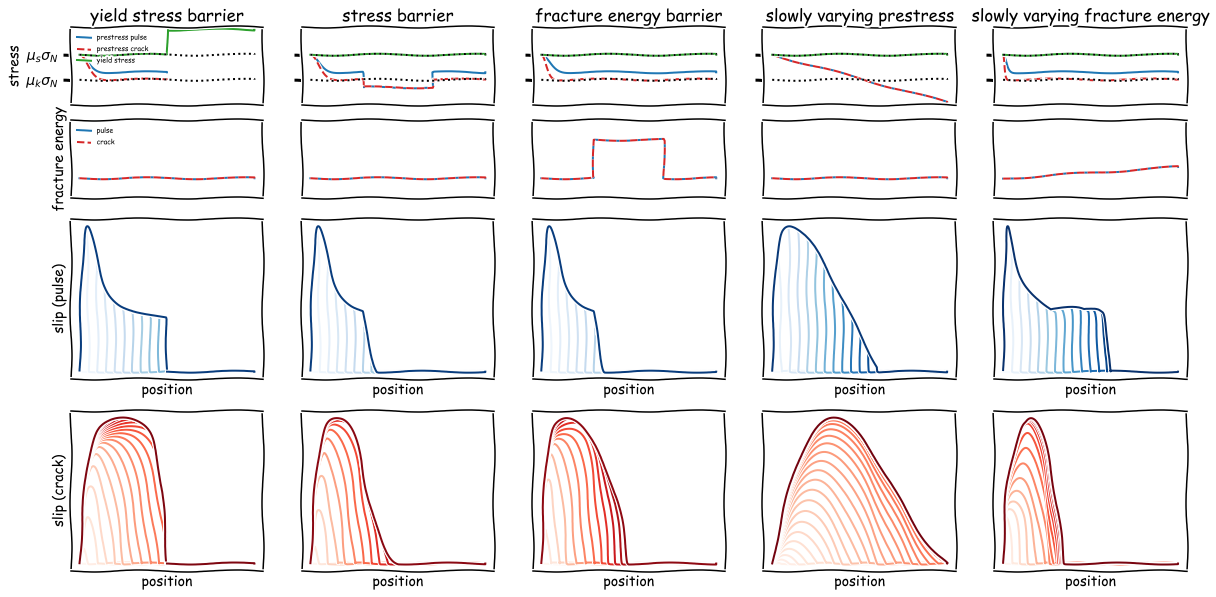

In [4]:
import numpy as np 
import matplotlib.pyplot as plt

%matplotlib inline
with plt.xkcd():
    plt.figure(figsize=(20,10))
    plotind = 0
    for simulation in ['yield stress barrier','stress barrier','fracture energy barrier', 'slowly varying prestress', 'slowly varying fracture energy']:
        ax = plt.subplot(6,5,plotind+1)
        ax.plot(data[plotind]['x'],data[plotind]['tau'],'tab:blue',label='prestress pulse')
        ax.plot(dataCrack[plotind]['x'],dataCrack[plotind]['tau'],'tab:red',linestyle='--', label = 'prestress crack')        
        if simulation == 'yield stress barrier':
            x = np.linspace(0,100,10000)
            ax.plot(x,(x>50) + 1, 'tab:green',label='yield stress')
            ax.plot(x,x*0, 'k', linestyle = 'dotted')
            ax.plot(x,x*0+1, 'k', linestyle = 'dotted')            
        else:
            ax.plot(data[plotind]['x'],np.ones(np.size(data[plotind]['x'])),'tab:green',label='yield stress')   
            ax.plot(data[plotind]['x'],data[plotind]['x']*0, 'k', linestyle = 'dotted')
            ax.plot(data[plotind]['x'],data[plotind]['x']*0+1, 'k', linestyle = 'dotted')            

        ax.set_yticks([0,1])
        if plotind==0:
            ax.set_yticklabels(['$\mu_k \sigma_N$','$\mu_s \sigma_N$'])
            ax.set_ylabel('stress')
            ax.legend(fontsize=7,frameon=False,loc=2)
        else:
            ax.set_yticklabels(['',''])

        ax.set_xticks([])
        ax.set_ylim([-1,2.1])
        ax.set_title(simulation)

        ax = plt.subplot(6,5,plotind+6)
        ax.plot(data[plotind]['x'],data[plotind]['frictionLaw'].dc,'tab:blue', label = 'pulse')
        ax.plot(dataCrack[plotind]['x'],dataCrack[plotind]['frictionLaw'].dc,'tab:red',linestyle = '--', label = 'crack')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim([-.5,1.5])
        if plotind==0:
            ax.set_ylabel('fracture energy')
            ax.legend(fontsize=7,frameon=False,loc=2)

        ax = plt.subplot(3,5,plotind+6)
        maxT = len(data[plotind]['t'])
        
        for i in range(0,len(data[plotind]['t']),round(50)):
            ax.plot(data[plotind]['x'],data[plotind]['u'][:,i]/np.max(data[plotind]['u']),color=plt.cm.Blues(np.linspace(0,1,maxT))[i])
            if simulation == 'yield stress barrier':
                ax.plot(data[plotind]['x']+np.max(data[plotind]['x']),data[plotind]['u'][:,i]*0,color=plt.cm.Blues(np.linspace(0,1,maxT))[i])
            ax.set_yticks([])
            ax.set_xticks([])

            if plotind==0:
                ax.set_ylabel('slip (pulse)')

            ax.set_xlabel('position')
            
        ax = plt.subplot(3,5,plotind+11)
        maxT = len(dataCrack[plotind]['t'])
        if simulation=='yield stress barrier':
            maxT = round(maxT/2)
        for i in range(0,maxT,round(50)):
            ax.plot(dataCrack[plotind]['x'],dataCrack[plotind]['u'][:,i]/np.max(dataCrack[plotind]['u']),color=plt.cm.Reds(np.linspace(0,1,maxT))[i])
            if simulation == 'yield stress barrier':
                ax.plot(dataCrack[plotind]['x']+np.max(dataCrack[plotind]['x']),dataCrack[plotind]['u'][:,i]*0,color=plt.cm.Reds(np.linspace(0,1,maxT))[i])
            ax.set_yticks([])
            ax.set_xticks([])

            if plotind==0:
                ax.set_ylabel('slip (crack)')

            ax.set_xlabel('position')

        plotind += 1

    plt.savefig('figures/sketch.png', format='png', dpi = 300)
    plt.show()